# Pre-training a ScafVAE
## Step 1. Loading dependencies
Please select a folder for temporary saving (in this demo, we use ./cache) and change the path of model_param_path in ScafVAE_ROOT/model/config.yml to it.

In [1]:
import random

cache_path = './cache'  # for saving data and model
%store cache_path

device = 'cuda:0'
%store device

Stored 'cache_path' (str)
Stored 'device' (str)


In [2]:
import os
os.system(f'rm -rf {cache_path}')
from ScafVAE.app.app_utils import *
from ScafVAE.utils.common import *

delmkdir(cache_path)

## Step 2. Data preparation
### Loading dataset

In [3]:
smi_list = get_demo_smi()[:2000]  # We load a small molecule set derived from the ChEMBL database. You can load your own molecule set here (a list of SMILES)
smi_list[:3]

['CCCCN1C(=O)C(CC(=O)O)NC(=O)C12CCN(Cc1ccc(Oc3ccccc3)cc1)CC2',
 'COC(=O)[C@H](NC(=O)CC(=O)O)C(C)C',
 'C[C@H](NCC(=O)Nc1cccc(Br)c1)c1ccc(C(F)F)nc1']

### Preparing features for molecules

In [4]:
prepare_demo_smi_feat(cache_path, smi_list)

Preparing molecular features: 100%|██████████| 2000/2000 [02:02<00:00, 16.36it/s]


### Calculating bond perplexity

In [5]:
prepare_demo_ppl(cache_path, device=device)

100%|██████████| 62/62 [02:09<00:00,  2.10s/it]


### Perplexity-inspired fragmentation

In [6]:
prepare_demo_scaf(cache_path)

Preparing scaffolds: 100%|██████████| 1960/1960 [00:36<00:00, 53.93it/s]

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


Unique bond scaffold: 360


Counting scaffolds: 100%|██████████| 1559/1559 [00:01<00:00, 887.04it/s]


## Step 3. Training
Please replace "unique_xxx.csv" and "scaf_xxx.npz" in "ScafVAE_ROOT/params/" with the files generated in Step2 (in cache_path), and restart the Python kernel to reload the prepared configurations !!!

In [10]:
# Replace "unique_xxx.csv" and "scaf_xxx.npz" in "ScafVAE_ROOT/params/" with the files generated in Step2 (in cache_path) (backup first !!!).
# Restart the Python kernel to reload the new configurations.

from ScafVAE.app.app_utils import *
%store -r cache_path
%store -r device

model, config = train_toy_model(
    cache_path,
    device=device,
    batch_size=16,
    n_epoch=20,
    lr=1e-3,
)
torch.save({'model_state_dict': model.state_dict(), 'args': config}, f'{cache_path}/ScafVAE.chk')  # save model

Loading ScafVAE parameters ...
Epoch: 1, lr: 0.00e+00
68/68 [==============================] - 64s 945ms/step - fp_acc: 0.7994 - x_scaf_pred_metric: 27.0665 - edge_scaf_pred_metric: 5.4379 - x_aa_pred_metric: 22.6642 - edge_bond_pred_metric: 12.2042 - kl_metric: 435.7975 - cl_metric: 3.3739 - cl_embed_1_norm_penalty: 45.2235 - cl_embed_2_norm_penalty: 45.1072 - fp_metric: 0.4489
Epoch: 2, lr: 9.97e-04
68/68 [==============================] - 63s 921ms/step - fp_acc: 0.8500 - x_scaf_pred_metric: 23.9837 - edge_scaf_pred_metric: 4.7930 - x_aa_pred_metric: 10.5862 - edge_bond_pred_metric: 10.9718 - kl_metric: 486.8051 - cl_metric: 3.0197 - cl_embed_1_norm_penalty: 15.7906 - cl_embed_2_norm_penalty: 15.7492 - fp_metric: 0.3859
Epoch: 3, lr: 9.82e-04
68/68 [==============================] - 63s 933ms/step - fp_acc: 0.8521 - x_scaf_pred_metric: 23.3914 - edge_scaf_pred_metric: 4.6851 - x_aa_pred_metric: 9.5964 - edge_bond_pred_metric: 10.4498 - kl_metric: 399.2792 - cl_metric: 2.7651 - cl_em

## Step 4. Visualization

### Sampling molecules

In [24]:
n_sample = 100
batch_size = 50

model.train(False)
dic_save = defaultdict(list)
for _ in tqdm(range(n_sample // batch_size)):
    dic_output = model.frag_decoder.sample(
        batch_size=batch_size,
    )
    dic_save['generated_smi'] += dic_output['smi']

valid_smi = [i for i in dic_save['generated_smi'] if i is not None][:n_sample]
print(f'Valid moleucles: {len(valid_smi)}')

100%|██████████| 2/2 [00:02<00:00,  1.02s/it]

Valid moleucles: 100


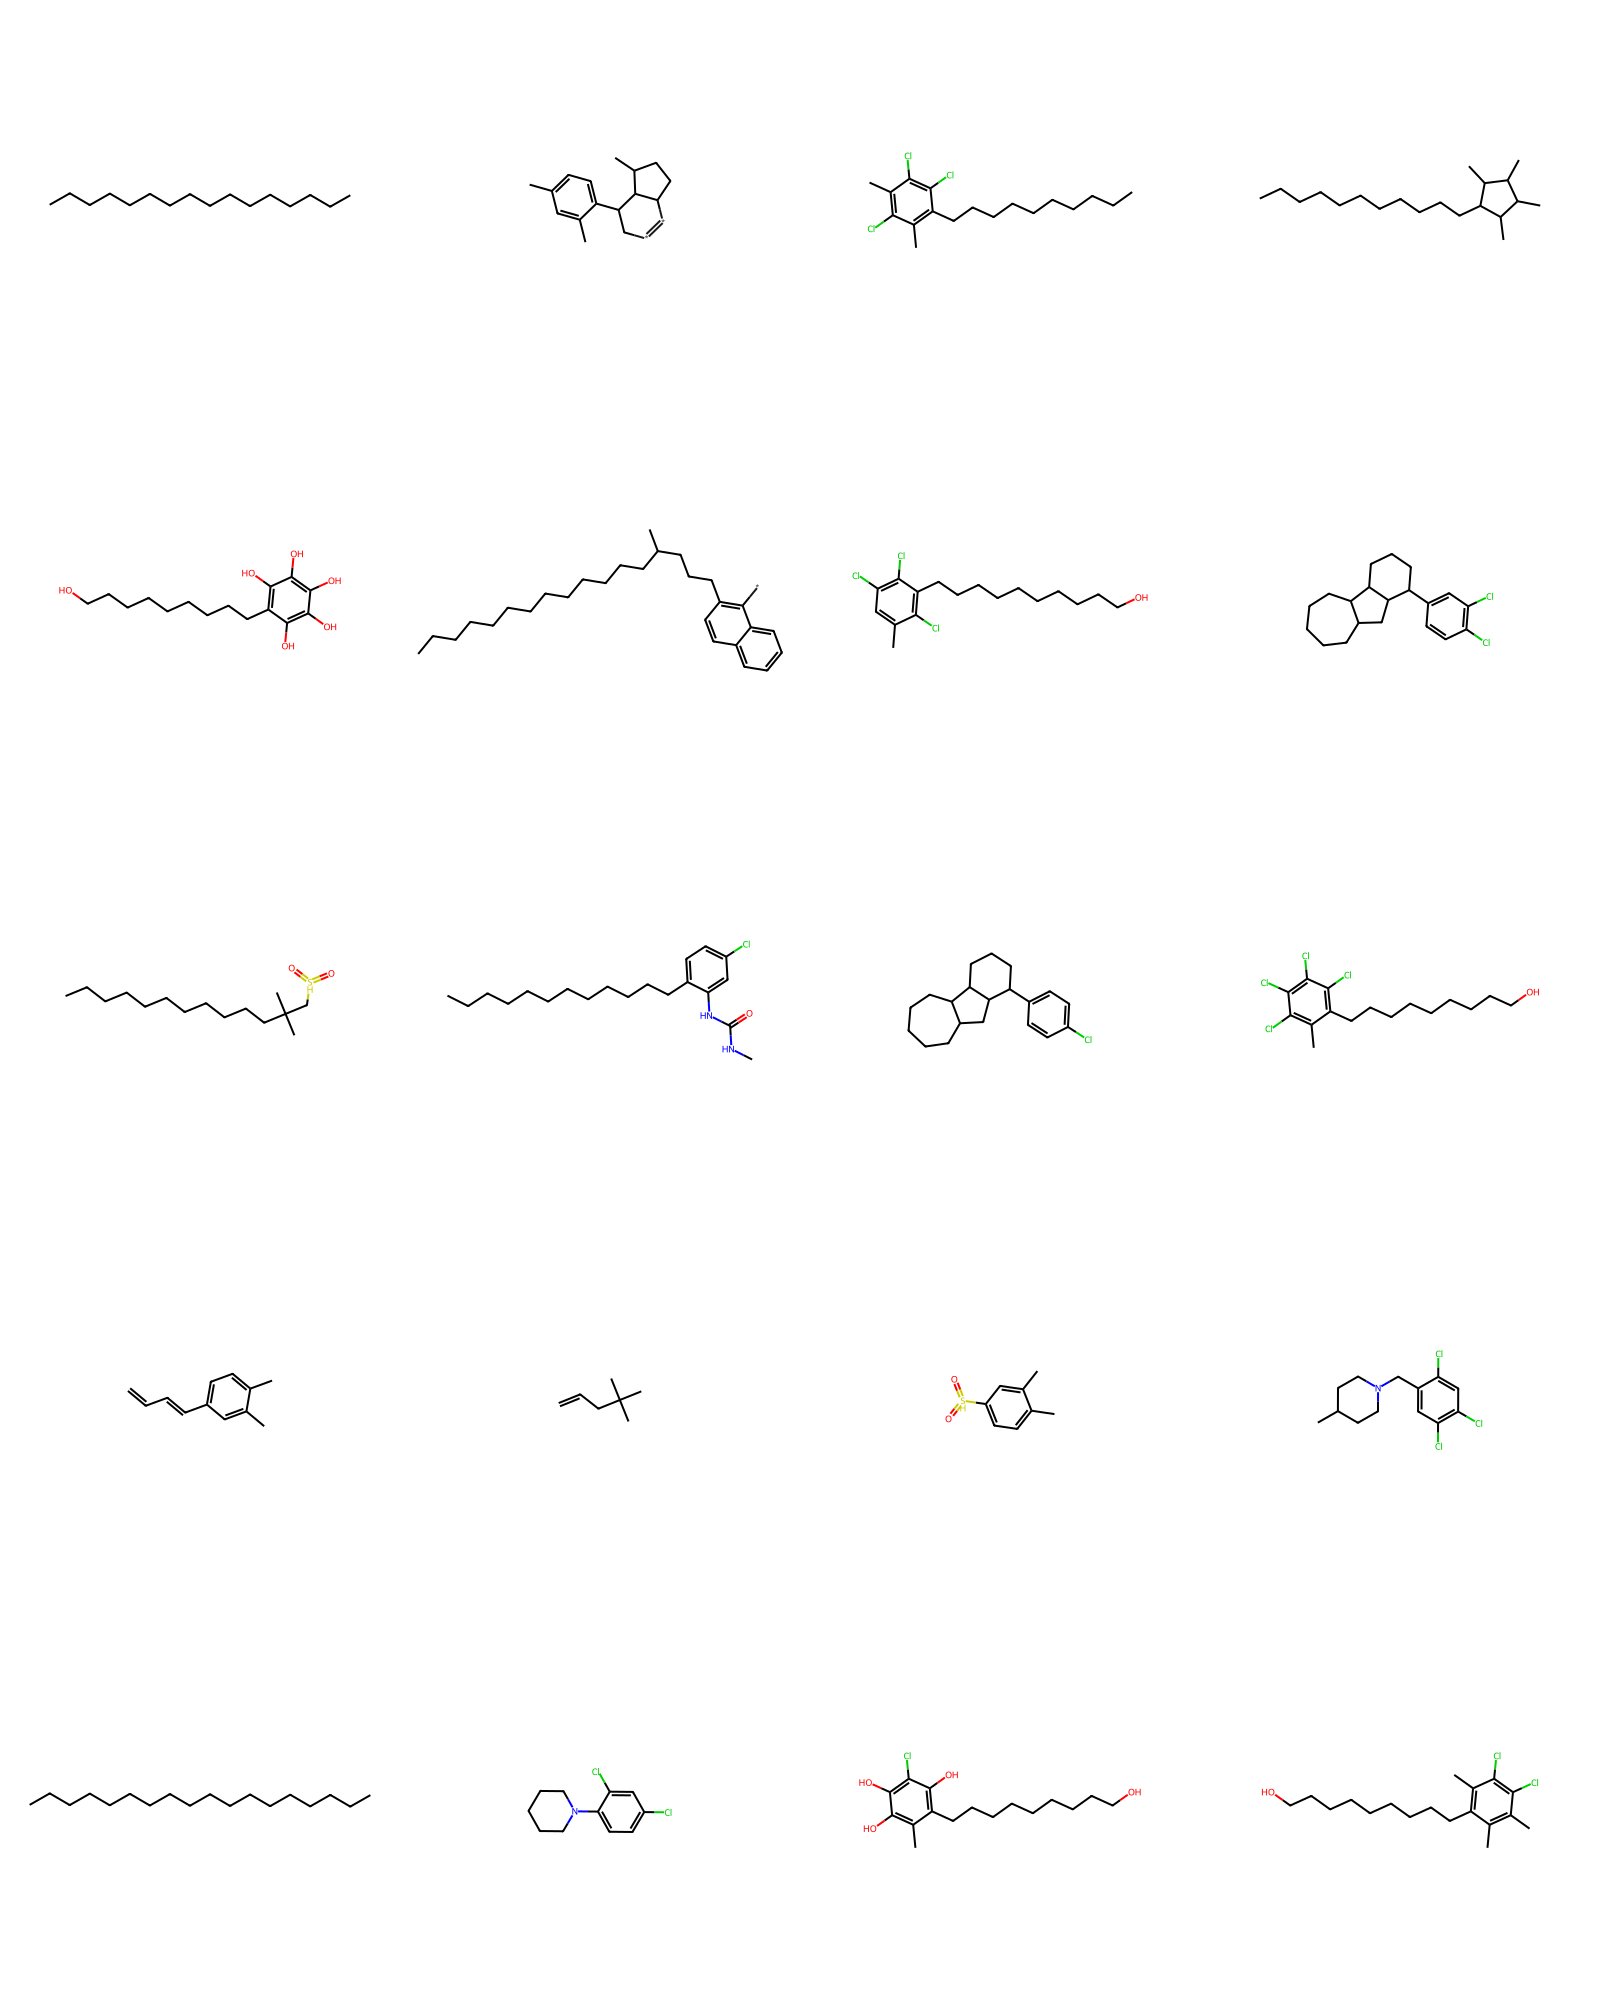

In [26]:
random.shuffle(valid_smi)
show_mols([Chem.MolFromSmiles(smi) for smi in valid_smi][:20], add_idx=False)